In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [13]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [14]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'HRV' 'ISL' 'IRL' 'ITA' 'HUN' 'LVA' 'GBR' 'FRA' 'LTU' 'AUT' 'SVN'
 'FIN' 'ESP' 'NOR' 'BGR' 'PRT' 'SVK' 'BEL' 'EST' 'POL' 'CZE' 'NLD' 'CHE'
 'DNK' 'SWE']


,path,label
16130,/home/pascal_steiger/Downloads/data/BGR/img_BG...,BGR
18147,/home/pascal_steiger/Downloads/data/SVK/img_SV...,SVK
16199,/home/pascal_steiger/Downloads/data/BGR/img_BG...,BGR
21900,/home/pascal_steiger/Downloads/data/CZE/img_CZ...,CZE
4907,/home/pascal_steiger/Downloads/data/ITA/img_IT...,ITA
14897,/home/pascal_steiger/Downloads/data/NOR/img_NO...,NOR
15502,/home/pascal_steiger/Downloads/data/NOR/img_NO...,NOR
18039,/home/pascal_steiger/Downloads/data/SVK/img_SV...,SVK
3239,/home/pascal_steiger/Downloads/data/IRL/img_52...,IRL
15466,/home/pascal_steiger/Downloads/data/NOR/img_NO...,NOR


In [15]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                    path label
26437  /home/pascal_steiger/Downloads/data/SWE/img_SW...   SWE
14871  /home/pascal_steiger/Downloads/data/NOR/img_NO...   NOR
23434  /home/pascal_steiger/Downloads/data/NLD/img_51...   NLD
21293  /home/pascal_steiger/Downloads/data/POL/img_PO...   POL
691    /home/pascal_steiger/Downloads/data/MKD/img_MK...   MKD
(21234, 2)
                                                    path label
18216  /home/pascal_steiger/Downloads/data/SVK/img_SV...   SVK
1822   /home/pascal_steiger/Downloads/data/HRV/img_HR...   HRV
8174   /home/pascal_steiger/Downloads/data/FRA/img_48...   FRA
7112   /home/pascal_steiger/Downloads/data/GBR/img_50...   GBR
11794  /home/pascal_steiger/Downloads/data/SVN/img_SV...   SVN
(5309, 2)


In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 21234 validated image filenames belonging to 26 classes.
Found 5309 validated image filenames belonging to 26 classes.


In [18]:
with tf.device("/device:GPU:0"):
    from tensorflow.keras.applications.xception import Xception
    tl_xcep = Xception(include_top=True,weights="imagenet")
    for layer in tl_xcep.layers:
        layer.trainable = False

    for layer in tl_xcep.layers[-26:]:
        layer.trainable = True 
    print(tl_xcep.summary())

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [19]:
with tf.device("/device:GPU:0"):
    tl_xcep.layers.pop()
    tl_xcep.layers.pop()
    tl_xcep.layers.pop()


    I = Input(shape=(299, 299, 3))



    x = tl_xcep(I)

    flat= Flatten()(x)


    dense = Dense(4096, activation='relu', name='denserelu')(flat)
    
    dropout = Dropout(0.3)(dense)

    dense2 = Dense(2048, activation='relu', name='denserelu2')(dropout)
    
    dropout2 = Dropout(0.1)(dense2)

    dense3 = Dense(26, activation='softmax', name='my_dense')(dropout2)

    #prediction = Dense(26, activation='softmax', name='prediction')



    #out2 = prediction(x)


    new_model2 = tf.keras.Model(I, dense3)

    new_model2.summary()





Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 1000)              22910480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
denserelu (Dense)            (None, 4096)              4100096   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
denserelu2 (Dense)           (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0     

In [20]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [21]:
with tf.device("/device:GPU:0"):
    new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:0"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          #steps_per_epoch=2000 // 32,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_xcep_v2.h5')

Epoch 1/200
664/664 [==============================] - 575s 854ms/step - loss: 3.1115 - sparse_categorical_accuracy: 0.0890 - val_loss: 2.8947 - val_sparse_categorical_accuracy: 0.1522
Epoch 2/200
664/664 [==============================] - 551s 830ms/step - loss: 2.7008 - sparse_categorical_accuracy: 0.1627 - val_loss: 2.5006 - val_sparse_categorical_accuracy: 0.2032
Epoch 3/200
664/664 [==============================] - 581s 875ms/step - loss: 2.4286 - sparse_categorical_accuracy: 0.2355 - val_loss: 2.2931 - val_sparse_categorical_accuracy: 0.2869
Epoch 4/200
664/664 [==============================] - 547s 823ms/step - loss: 2.2080 - sparse_categorical_accuracy: 0.3065 - val_loss: 2.1579 - val_sparse_categorical_accuracy: 0.3187
Epoch 5/200
664/664 [==============================] - 548s 826ms/step - loss: 2.0348 - sparse_categorical_accuracy: 0.3538 - val_loss: 2.0323 - val_sparse_categorical_accuracy: 0.3601
Epoch 6/200
664/664 [==============================] - 543s 817ms/step - lo

664/664 [==============================] - 535s 806ms/step - loss: 0.2778 - sparse_categorical_accuracy: 0.9138 - val_loss: 2.9557 - val_sparse_categorical_accuracy: 0.4845
Epoch 46/200
664/664 [==============================] - 541s 814ms/step - loss: 0.2849 - sparse_categorical_accuracy: 0.9115 - val_loss: 2.6919 - val_sparse_categorical_accuracy: 0.4935

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 47/200
664/664 [==============================] - 536s 808ms/step - loss: 0.1797 - sparse_categorical_accuracy: 0.9434 - val_loss: 3.0588 - val_sparse_categorical_accuracy: 0.4992
Epoch 48/200
664/664 [==============================] - 540s 813ms/step - loss: 0.1519 - sparse_categorical_accuracy: 0.9512 - val_loss: 3.0088 - val_sparse_categorical_accuracy: 0.5037
Epoch 49/200
664/664 [==============================] - 544s 819ms/step - loss: 0.1419 - sparse_categorical_accuracy: 0.9542 - val_loss: 3.1220 - val_sparse_categorical_accuracy: 0.5020
Ep

Epoch 88/200
664/664 [==============================] - 512s 771ms/step - loss: 0.0335 - sparse_categorical_accuracy: 0.9894 - val_loss: 3.5750 - val_sparse_categorical_accuracy: 0.5278

Epoch 00088: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 89/200
664/664 [==============================] - 512s 771ms/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9906 - val_loss: 3.5564 - val_sparse_categorical_accuracy: 0.5349
Epoch 90/200
664/664 [==============================] - 517s 778ms/step - loss: 0.0260 - sparse_categorical_accuracy: 0.9922 - val_loss: 3.5831 - val_sparse_categorical_accuracy: 0.5357
Epoch 91/200
664/664 [==============================] - 516s 776ms/step - loss: 0.0245 - sparse_categorical_accuracy: 0.9929 - val_loss: 3.6428 - val_sparse_categorical_accuracy: 0.5283
Epoch 92/200
664/664 [==============================] - 518s 779ms/step - loss: 0.0222 - sparse_categorical_accuracy: 0.9929 - val_loss: 3.7472 - val_sparse_categorical_accurac

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


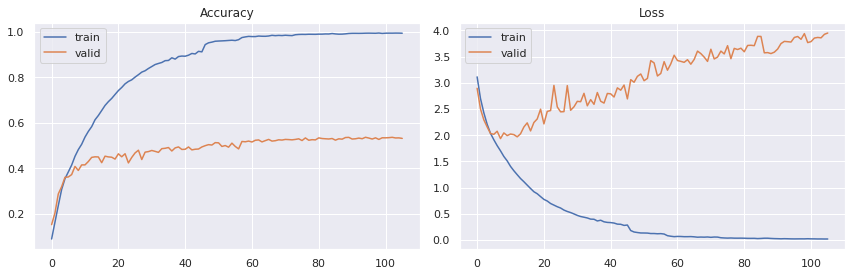

In [22]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(299,299)-tl_xcepv2.png')

plt.show()

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        "/mnt/data/testing3/",
        target_size=(224, 224),
        batch_size=1,
        class_mode='sparse',
        shuffle=False)

res=validmodel2.predict(test_generator, steps=len(test_generator), verbose=1)
y_classes = res.argmax(axis=-1)
print(labelStringArr)
label2 = np.sort(labelStringArr)
print(label2)
print(y_classes)

filenames=test_generator.filenames
label_map = (train_generator.class_indices)
print(label_map)
preds = []
labels = []
for i in range(len(filenames)):
    #print(res[i])
    preds.append(res[i][np.argmax(res[i])])
    labels.append(label2[y_classes[i]])




# Data frame
results=pd.DataFrame({"file":filenames, "class":labels, "pr":preds})

results.to_csv("res2.csv", index = False)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/testing3/'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=5309
batch_size=32
Y_pred = validmodel2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = label2
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))